## How many of the Top 200 songs occur on both the US and Global charts? 

Timeframe: past 52 weeks

Observations:
1. 829 songs are common across both charts
 - This comprises 64% of the US chart and 72% of the Global chart <br>
<br> 
- Although the US has fewer common songs in the Top 200, the common songs comprise a large percent of streams
 - Common songs comprise 90% of streams in the US and 84% of streams globally
 - Question:  Are there songs on either chart with high streams that do not cross over to the other chart?
 - Question:  If there are such songs, what differentiates them from songs that cross over?<br>
<br>
- There appear to be two different types of songs that are common to both charts:
 - Those with a high correlation of weeks in the chart (globally popular) and those with no correlation
 - Question: What are the attributes that distinguish the two subsets?

Additional questions:
- Is there a time factor indicating direction of influence (timing of when common songs show up on one chart vs the other)?


In [1]:
# Dependencies and 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from datetime import datetime, timedelta
from scipy.stats import linregress

# data files
US_path = "Combined CSVs/US_combined.csv"
Global_path = "Combined CSVs/Global_combined.csv"

# Read the mouse data and the study results
us_data = pd.read_csv(US_path)
global_data = pd.read_csv(Global_path)


In [2]:
# prep US data

# create unique Artist Track field and display column headers in US data
us_data["ArtistTrack"] = us_data["Artist"] + us_data["Track Name"]

# drop headers in data and convert Streams to integer - US data
us_data.drop(us_data[us_data.Position == "Position"].index, inplace=True)
us_data["Position"] = us_data["Position"].astype(int)
us_data["Streams"] = us_data["Streams"].astype(int)
us_data["Artist"] = us_data["Artist"].str.replace('$','S')
us_data["Track Name"] = us_data["Track Name"].str.replace('$','S')



In [3]:
# prep Global data

# create unique Artist Track field and display column headers in Global data
global_data["ArtistTrack"] = global_data["Artist"] + global_data["Track Name"]

# drop headers in data and convert Streams to integer - Global data
global_data.drop(global_data[global_data.Position == "Position"].index, inplace=True)
global_data["Position"] = global_data["Streams"].astype(int)
global_data["Streams"] = global_data["Streams"].astype(int)
global_data["Artist"] = global_data["Artist"].str.replace('$','S')
global_data["Track Name"] = global_data["Track Name"].str.replace('$','S')


In [4]:
# baseline counts
print("Input counts:")
us_data_recs_in = len(us_data)
global_data_recs_in = len(global_data)
print(f"rows in us: {us_data_recs_in}")
print(f"rows in global: {global_data_recs_in}")

us_dates_in = us_data["Date"].value_counts()
global_dates_in = global_data["Date"].value_counts()
print(f"unique dates in us: {len(us_dates_in)}")
print(f"unique dates in global: {len(global_dates_in)}")
     

Input counts:
rows in us: 10400
rows in global: 10400
unique dates in us: 52
unique dates in global: 52


In [8]:
# print scatter charter and regression analsys

def print_scatter_and(x_axis, y_axis, title, x_label, y_label, y_lim=0):

    # make x_axis amenable to calculation of regression values
    x_axis = np.asarray(x_axis)
    
    # run linregress to get components for correlaton coefficient and regression model
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis,  y_axis)
    regress_values = x_axis * slope + intercept

    # calc correlation coefficient and format regression model equation
    correlation_coefficient = round(rvalue**2, 2)
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # figure out where to place the regression model equation
    test_val = (slope*max(x_axis) + intercept) - (slope*min(x_axis) + intercept)
    x_pos = min(x_axis)
    if test_val > 0:
        if max(y_axis) > 25:
            y_pos = max(y_axis) - 5
        else:
            y_pos = max(y_axis) - 1
    else:
        if max(y_axis) > 25:
            y_pos = min(y_axis) + 5
        else:
            y_pos = min(y_axis) + 1

    # format and print plot
    fig = plt.figure()
    plt.scatter(x_axis, y_axis, marker="o", facecolors="#79abcd")
    plt.plot(x_axis,regress_values,"#f70d30")
    plt.annotate(line_eq,(x_pos,y_pos),fontsize=15,color="#f70d30",fontweight="bold")
    fig.suptitle(title, fontsize=12)
    if y_lim > 0:
        plt.ylim(top=y_lim)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    print(f'Correlation coefficient = {correlation_coefficient}')
    print('')

In [9]:
# summarize line item detail by song (artist and track) for each chart

us_groupby = us_data.groupby(["ArtistTrack"])
us_track_df = pd.DataFrame(us_groupby["Artist"].max())
us_track_df["Track Name"] = us_groupby["Track Name"].max()
us_track_df["Weeks in Top 200"] = us_groupby["Position"].count()
us_track_df["Top Position"] = us_groupby["Position"].min()
us_track_df["Low Position"] = us_groupby["Position"].max()
us_track_df["Total Streams"] = us_groupby["Streams"].sum()

global_groupby = global_data.groupby(["ArtistTrack"])
global_track_df = pd.DataFrame(global_groupby["Artist"].max())
global_track_df["Track Name"] = global_groupby["Track Name"].max()
global_track_df["Weeks in Top 200"] = global_groupby["Position"].count()
global_track_df["Top Position"] = global_groupby["Position"].min()
global_track_df["Low Position"] = global_groupby["Position"].max()
global_track_df["Total Streams"] = global_groupby["Streams"].sum()

#global_track_df.head()

In [10]:
# create dataframe of songs common to both charts using inner join

common_track_df = pd.merge(us_track_df, global_track_df, how='inner', on='ArtistTrack', suffixes=('_US', '_GL'))

#common_track_df.head()

In [11]:
# Streams - raw and formatted for print

one_billion = 1000000000
one_million = 1000000

# calculate raw totals
total_streams_US = us_track_df["Total Streams"].sum()
total_streams_GL = global_track_df["Total Streams"].sum()
total_common_streams_US = common_track_df["Total Streams_US"].sum()
total_common_streams_GL = common_track_df["Total Streams_GL"].sum()

total_unique_streams_US = total_streams_US - total_common_streams_US
total_unique_streams_GL = total_streams_GL - total_common_streams_GL

# format totals for printing
# US total streams
if total_streams_US > one_billion:
    denominator = one_billion
    stream_label_US = "billion"
else:    
    denominator = one_million
    stream_label_US = "million"

total_streams_US_f = float("{:.1f}".format(total_streams_US / denominator))
common_streams_US_f = float("{:.1f}".format(total_common_streams_US / denominator))
total_unique_streams_US_f = float("{:.1f}".format(total_unique_streams_US / denominator))

# Global total streams
if total_streams_GL > one_billion:
    denominator = one_billion
    stream_label_GL = "billion"
else:    
    denominator = one_million
    stream_label_GL = "million"

total_streams_GL_f = float("{:.1f}".format(total_streams_GL / denominator))
common_streams_GL_f = float("{:.1f}".format(total_common_streams_GL / denominator))
total_unique_streams_GL_f = float("{:.1f}".format(total_unique_streams_GL / denominator))

streams_bars_df = pd.DataFrame({"US":[total_common_streams_US, total_unique_streams_US],
                                "Global":[total_common_streams_GL, total_unique_streams_GL]})


In [12]:
# Song counts
# calculate song counts for each chart and for common songs

total_songs_US = len(us_track_df)
total_songs_GL = len(global_track_df)
total_songs_common = len(common_track_df)

total_unique_songs_US = total_songs_US - total_songs_common
total_unique_songs_GL = total_songs_GL - total_songs_common


In [13]:
# calculate and format percentages

# common streams as percent of total US streams
common_streams_pct_US = float("{:.1f}".format((total_common_streams_US / total_streams_US) * 100))

# unique US streams as percent of total US streams
unique_streams_pct_US = float("{:.1f}".format(100 - common_streams_pct_US))

# common streams as percent of total Global streams
common_streams_pct_GL = float("{:.1f}".format((total_common_streams_GL / total_streams_GL) * 100))

# unique streams as percent of total Global streams
unique_streams_pct_GL = float("{:.1f}".format(100 - common_streams_pct_GL))

# common songs as percent of total US songs
common_songs_pct_US = float("{:.1f}".format((total_songs_common / total_songs_US) * 100))

# unique songs as percent of total US songs
unique_songs_pct_US = float("{:.1f}".format(100 - common_songs_pct_US))

# common songs as percent of total Global songs
common_songs_pct_GL = float("{:.1f}".format((total_songs_common / total_songs_GL) * 100))

# unique songs as percent of total Global songs
unique_songs_pct_GL = float("{:.1f}".format(100 - common_songs_pct_GL))

In [15]:
# print summary information

print("")
print(f"The US Top 200 chart contains {total_songs_US} songs totaling {total_streams_US_f} {stream_label_US} streams")
print(f"The Global Top 200 chart contains {len(global_track_df)} songs totaling {total_streams_GL_f} {stream_label_GL} streams")
print(f"{total_songs_common} songs are common across both charts")
print("")

# Find artist(s) with most songs on both charts
# (started building logic to account for multiple artists with same number of songs, 
# but stopped when I realized there was only one)
#
Artist_with_most_songs = common_track_df["Artist_US"].mode()
if len(Artist_with_most_songs) == 1:
    ArtistX = Artist_with_most_songs[0]
    SongsX_df = common_track_df.loc[common_track_df["Artist_US"] == ArtistX]
    ArtistX_streams_US =  common_track_df.loc[common_track_df["Artist_US"] == ArtistX, "Total Streams_US"].sum()
    ArtistX_streams_GL =  common_track_df.loc[common_track_df["Artist_US"] == ArtistX, "Total Streams_GL"].sum()
    ArtistX_pct_US = float("{:.1f}".format((ArtistX_streams_US / total_streams_US) * 100))
    ArtistX_pct_GL = float("{:.1f}".format((ArtistX_streams_GL / total_streams_GL) * 100))
    
    print(f"The artist with the most songs common to both charts is {ArtistX} with {len(SongsX_df)} songs")
    print(f" - US streams of {ArtistX}: {ArtistX_streams_US:,} ({ArtistX_pct_US}% of total US streams)")
    print(f" - Global streams of {ArtistX}: {ArtistX_streams_GL:,} ({ArtistX_pct_GL}% of total global streams)")
    print("")

# Identify songs with longest run in each chart
# longest run
longest_run_US = common_track_df["Weeks in Top 200_US"].max()
longest_run_GL = common_track_df["Weeks in Top 200_GL"].max()

# songs with longest run
longest_run_songs_US_df = common_track_df.loc[common_track_df["Weeks in Top 200_US"] == longest_run_US]
longest_run_songs_GL_df = common_track_df.loc[common_track_df["Weeks in Top 200_GL"] == longest_run_GL]

print(f"There were {len(longest_run_songs_US_df)} songs that stayed in the US Top 200 for {longest_run_US} weeks")
print(f"There were {len(longest_run_songs_GL_df)} songs that stayed in the Global Top 200 for {longest_run_US} weeks")

# hmmm... revisit the logic of this
#common_longest_df = pd.merge(longest_run_songs_US_df, longest_run_songs_GL_df, how='inner', on='ArtistTrack')
#len(common_longest_df)

#if longest_run_US > longest_run_GL:
#    print(f"There were {len(common_longest_df)} songs that stayed in the both charts for {longest_run_US} weeks")
#else:
#    print(f"There were {len(common_longest_df)} songs that stayed in the both charts for {longest_run_GL} weeks")

print("")



The US Top 200 chart contains 1302 songs totaling 28.8 billion streams
The Global Top 200 chart contains 1140 songs totaling 93.3 billion streams
829 songs are common across both charts

The artist with the most songs common to both charts is Lil Uzi Vert with 33 songs
 - US streams of Lil Uzi Vert: 735,646,471 (2.6% of total US streams)
 - Global streams of Lil Uzi Vert: 760,042,873 (0.8% of total global streams)

There were 26 songs that stayed in the US Top 200 for 52 weeks
There were 23 songs that stayed in the Global Top 200 for 52 weeks



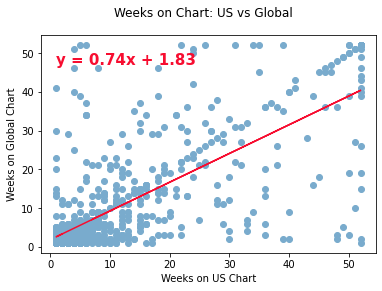

Correlation coefficient = 0.56




In [16]:
# Weeks on US chart vs Weeks on Global chart - common songs
print_scatter_and(common_track_df["Weeks in Top 200_US"], common_track_df["Weeks in Top 200_GL"], 
                  "Weeks on Chart: US vs Global", "Weeks on US Chart", "Weeks on Global Chart")
print("")

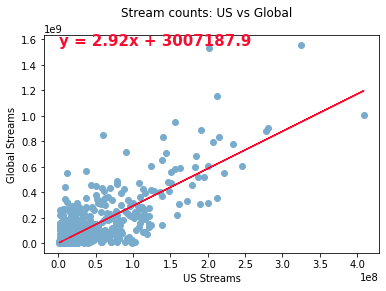

Correlation coefficient = 0.63




In [17]:
# US streams vs Global streams - common songs
print_scatter_and(common_track_df["Total Streams_US"], common_track_df["Total Streams_GL"], 
                  "Stream counts: US vs Global", "US Streams", "Global Streams")
print("")

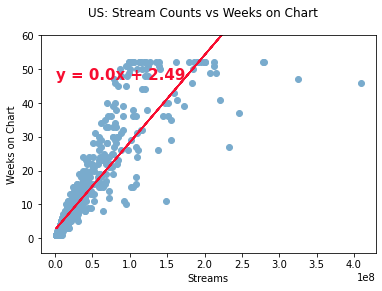

Correlation coefficient = 0.78




In [18]:
# US weeks on chart vs streams
print_scatter_and(common_track_df["Total Streams_US"], common_track_df["Weeks in Top 200_US"], 
                  "US: Stream Counts vs Weeks on Chart", "Streams", "Weeks on Chart",60)
print("")

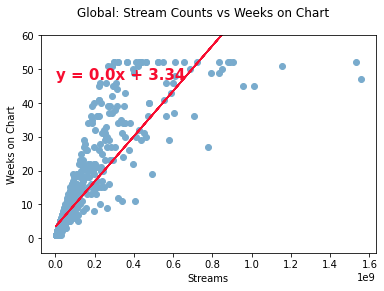

Correlation coefficient = 0.72




In [19]:
# Global weeks on chart vs streams
print_scatter_and(common_track_df["Total Streams_GL"], common_track_df["Weeks in Top 200_GL"], 
                  "Global: Stream Counts vs Weeks on Chart", "Streams", "Weeks on Chart",60)
print("")

In [20]:
# Observation:  Correlation of weeks on chart for common songs in general is not strong
#               but there appears to be a subset of that have a very high correlation    
# Question: Are there common attributes of the subset?  Could these be indicators of a song crossing over to another chart?
#
# Observation:  There are songs that have little to no correlation
# Question: Are there attributes that indicate that a song will not cross over to another chart (e.g, language)
# 

US common songs 63.7%, unique songs 36.3%
Global common songs 72.7%, unique songs 27.3%


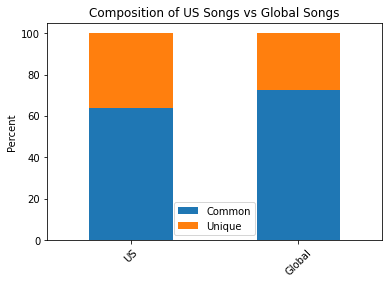

In [21]:
# Compare US Streams to Global Songs
songs_bars_df = pd.DataFrame({"Common":[common_songs_pct_US, common_songs_pct_GL],
                              "Unique":[unique_songs_pct_US, unique_songs_pct_GL]})
labels = ["US","Global"]
ax = songs_bars_df.plot.bar(stacked=True,title="Composition of US Songs vs Global Songs")
ax.set_xticklabels(labels,rotation=45)
ax.set_ylabel("Percent")

print(f"US common songs {common_songs_pct_US}%, unique songs {unique_songs_pct_US}%")
print(f"Global common songs {common_songs_pct_GL}%, unique songs {unique_songs_pct_GL}%")


US common streams 89.6%, unique streams 10.4%
Global common streams 83.6%, unique streams 16.4%


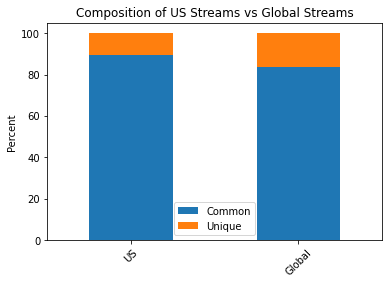

In [22]:
# Compare US Streams to Global Streams
streams_bars_df = pd.DataFrame({"Common":[common_streams_pct_US, common_streams_pct_GL],
                                "Unique":[unique_streams_pct_US, unique_streams_pct_GL]})
labels = ["US","Global"]
ax = streams_bars_df.plot.bar(stacked=True,title="Composition of US Streams vs Global Streams")
ax.set_xticklabels(labels,rotation=45)
ax.set_ylabel("Percent")

print(f"US common streams {common_streams_pct_US}%, unique streams {unique_streams_pct_US}%")
print(f"Global common streams {common_streams_pct_GL}%, unique streams {unique_streams_pct_GL}%")


In [23]:
# Observation:  US songs comprise a smaller percent of songs in the Top 200, but a larger percent of streams
# Question: How valid an indicator is stream counts that a song from the US Top 200 will appear in the Global Top 200?
#           Of songs in the US Top 200 with high stream counts, how many cross into the Global Top 200?
# Question: Is there and observable time factor between when a common song appears on one vs the other chart?
#           Who is the influencer?


<function matplotlib.pyplot.show(*args, **kw)>

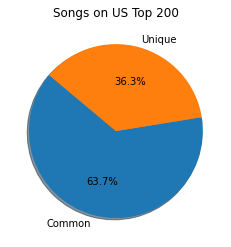

In [24]:
labels = ["Common", "Unique"]
counts = [total_songs_common, total_unique_songs_US]
colors = ["#1f77b4", "#ff7f0e"]
plt.pie(counts, labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)
plt.title("Songs on US Top 200")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

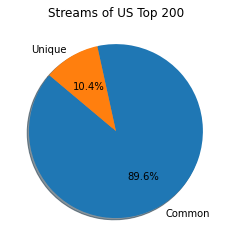

In [25]:
counts = [total_common_streams_US, total_unique_streams_US]
colors = ["#1f77b4", "#ff7f0e"]
plt.pie(counts, labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)
plt.title("Streams of US Top 200")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

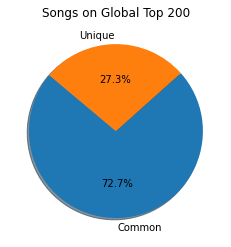

In [26]:
labels = ["Common", "Unique"]
counts = [total_songs_common, total_unique_songs_GL]
colors = ["#1f77b4", "#ff7f0e"]
plt.pie(counts, labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)
plt.title("Songs on Global Top 200")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

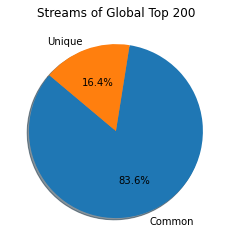

In [27]:
counts = [total_common_streams_GL, total_unique_streams_GL]
colors = ["#1f77b4", "#ff7f0e"]
plt.pie(counts, labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)
plt.title("Streams of Global Top 200")
plt.show